<a href="https://colab.research.google.com/github/YoheiFukuhara/recommender-system/blob/main/12_autorec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# config
batch_size = 128
epochs = 20
reg = 0.0001

BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/Recommend/output/'

In [ ]:
A = load_npz(BASE_PATH+"Atrain.npz")
A_test = load_npz(BASE_PATH+"Atest.npz")

# 評価がある要素を1に変換(評価がない要素は0)
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

In [ ]:
print(A_test.toarray()[0][:5])
print(mask_test.toarray()[0][:5]) # 

[0. 0. 0. 4. 0.]
[0. 0. 0. 1. 0.]


In [ ]:
# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

In [ ]:
N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

N: 4000 M: 1000
N // batch_size: 31


In [ ]:
# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

mu: 3.4696366855086516


In [ ]:
def custom_loss(y_true, y_pred):

    # 正解ラベルが0以外の場合は型をfloatに設定
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')

    # 自乗にmaskを乗算することで評価がある場合のみ算出できる
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = K.sum(K.sum(sqdiff)) # おそらく Sum Square Error
    n = K.sum(K.sum(mask)) # 評価ある場合の件数を分母に設定
    return sse / n

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 700)               700700    
                                                                 
 dense_1 (Dense)             (None, 1000)              701000    
                                                                 
Total params: 1,401,700
Trainable params: 1,401,700
Non-trainable params: 0
_________________________________________________________________


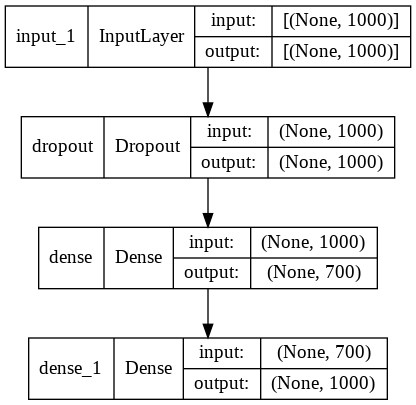

In [ ]:
# build the model - just a 1 hidden layer autoencoder
i = tf.keras.layers.Input(shape=(M,))
# bigger hidden layer size seems to help!
x = tf.keras.layers.Dropout(0.7)(i)
x = tf.keras.layers.Dense(700, activation='tanh', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg))(x)
x = tf.keras.layers.Dense(M, 
                          kernel_regularizer=tf.keras.regularizers.l2(reg))(x)

model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(
  loss=custom_loss,
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.08, momentum=0.9),
  metrics=[custom_loss],
)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def generator(A, M):
    while True:
        A, M = shuffle(A, M)
        for i in range(A.shape[0] // batch_size + 1): # ステップ数 を バッチサイズで除算 + 1回 繰り返す
            upper = min((i+1)*batch_size, A.shape[0]) # 処理対象行数(上限側)
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            a = a - mu * m # must keep zeros at zero!
            # m2 = (np.random.random(a.shape) > 0.5)
            # noisy = a * m2
            noisy = a # no noise
            yield noisy, a


def test_generator(A, M, A_test, M_test):
  # assumes A and A_test are in corresponding order
  # both of size N x M
    while True:
        for i in range(A.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, A.shape[0])
            a = A[i*batch_size:upper].toarray()
            m = M[i*batch_size:upper].toarray()
            at = A_test[i*batch_size:upper].toarray()
            mt = M_test[i*batch_size:upper].toarray()
            a = a - mu * m  # predict
            at = at - mu * mt # 正解ラベル(Lossは正解ラベルにあるものだけが反映)
            yield a, at

In [ ]:
%%time
# fit_generator is deprecated, so change from fit_generator to fit
r = model.fit(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)
print(r.history.keys())

Epoch 1/15
32/32 [==============================] - 1s 18ms/step - loss: 0.6745 - custom_loss: 0.5563 - val_loss: 0.7042 - val_custom_loss: 0.5867
Epoch 2/15
32/32 [==============================] - 0s 12ms/step - loss: 0.6661 - custom_loss: 0.5509 - val_loss: 0.6999 - val_custom_loss: 0.5841
Epoch 3/15
32/32 [==============================] - 0s 13ms/step - loss: 0.6582 - custom_loss: 0.5421 - val_loss: 0.6956 - val_custom_loss: 0.5815
Epoch 4/15
32/32 [==============================] - 0s 13ms/step - loss: 0.6514 - custom_loss: 0.5390 - val_loss: 0.6916 - val_custom_loss: 0.5793
Epoch 5/15
32/32 [==============================] - 1s 17ms/step - loss: 0.6424 - custom_loss: 0.5306 - val_loss: 0.6879 - val_custom_loss: 0.5772
Epoch 6/15
32/32 [==============================] - 1s 16ms/step - loss: 0.6362 - custom_loss: 0.5261 - val_loss: 0.6841 - val_custom_loss: 0.5749
Epoch 7/15
32/32 [==============================] - 0s 13ms/step - loss: 0.6311 - custom_loss: 0.5234 - val_loss: 0.68

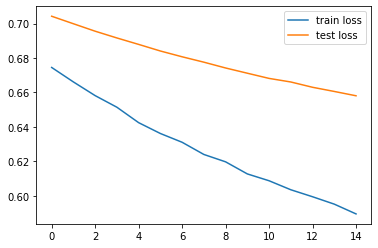

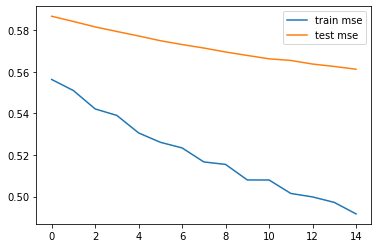

In [ ]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()